In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import re

from os import walk
from IPython.display import display
from pprint import pprint

import nltk
try:
    nltk.download(['crubadan'])
except Exception as err:
    print('*** ERROR ==>', err)
from nltk.classify.textcat import TextCat

# SQLAlchemy
from sqlalchemy import create_engine, Column, String, Integer
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.word2vec import Text8Corpus

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

from com.nait.lib.NLP.NLPTopic    import NLPTopic,    createTableNLPTopic
from com.nait.lib.NLP.NLPArticle  import NLPArticle,  createTableNLPArticle
from com.nait.lib.NLP.PubDocument import PubDocument, createTablePubDocument
from com.nait.lib.NLP.NLPDocument import NLPDocument
from com.nait.lib.NLP.NLPGrams    import NLPGrams

from com.nait.lib.NLP.util import utl_getTextPDF
from com.nait.lib.NLP.util import utl_getTextWord
from com.nait.lib.NLP.util import utl_documentToWords
from com.nait.lib.NLP.util import utl_computeCoherenceValues
from com.nait.lib.NLP.util import utl_documentTopics


[nltk_data] <urlopen error [Errno 11001] getaddrinfo failed>


c:\program files\anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
c:\program files\anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
c:\program files\anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """
C:\Users\id858480\___Lisaro\___Jupyter Notebooks\__HIVHack Kenya\com\nait\lib\NLP\NLPDocument.py:74: DeprecationWarning: invalid escape sequence \(
  v_url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
C:\Users\id858480\___Lisaro\___Jupyter Notebooks\__HIVHack Kenya\com\nait\lib\NLP\NLPDocument.py:80: DeprecationWarning: invalid escape sequence \S
  v_email_regex = '\S*@\S*\s?'


In [2]:
g_engine = create_engine('sqlite:///studiesInput/NLPDocuments.db')
g_recreateDB = False # if set to True, all tables will be dropped

# Number of keywords to be saved per topic
g_num_words = 60

# Global parameters used for LDAMallet model optimal topic search
g_start = 2
g_limit = 60 
g_step  = 2
g_iterations = 1200
        
# Global parameters used for the transformation between LDAMallet model and LDA model
g_gamma_threshold     = 0.001
g_random_state        = 42
g_minimum_phi_value   = 0.01
g_minimum_probability = 0.01
g_passes              = 1 # 180
g_update_every        = 1
g_eval_every          = 10
g_decay               = 0.5

In [3]:
Base = declarative_base()
Base.metadata.bind = g_engine
DBSession = sessionmaker(bind = g_engine)

def createSession():
    return DBSession()

if g_recreateDB:
    Base.metadata.create_all(g_engine)
    createTablePubDocument(g_engine)
    createTableNLPTopic(g_engine)
    createTableNLPArticle(g_engine)

In [4]:
v_session = createSession()
v_PubDocument = PubDocument('2135. Public Health Action')
v_PubDocument = v_PubDocument.loadFromDB(v_session)
if v_PubDocument:
    v_PubDocument.__content__     = None
    v_PubDocument.__contentSize__ = None
    v_PubDocument.__tokensList__  = []
    v_PubDocument.printShort('Empty ')
    v_PubDocument.recordIU(v_session, p_update = True)
v_session.close()

Empty  {'__lang__': 'fra', 'contentSize': None, 'tabPK': '2135. Public Health Action', 'tokensSize': 0}


### Split pubmed_abstract file

In [5]:
v_documents = pd.DataFrame()

try:
    with open(f'studiesInput/pubmed_abstract.txt', 'rb') as fileData:
        v_documentsPubmed = fileData.read().decode("utf-8-sig")
    v_documentsPubmed = v_documentsPubmed.split('[Indexed for MEDLINE]')
except Exception as err:
    print(f' ******* ERROR ==> {err}')
    v_documentsPubmed = []

v_session = createSession()
v_count = 0
for document in v_documentsPubmed[:]:
    v_count += 1
    document = document.strip()
    if len(document) < 10: continue
    
    v_document = document.split('\r\n\r\n')
    if v_document[0][:31] == 'Conflict of interest statement:':
        v_document = v_document[1:]
    
    v_data = []
    for item in v_document:
        item = item.replace('\r\n', ' ').strip()
        if len(item) > 1:
            v_data.append(item)
    v_document = v_data
    
    try:
        assert len(v_document) >= 5, f'Incorrect data for document (Cound not detect title) - {len(v_document)}!!!'
        v_paper     = v_document[0].split(';')[0].strip() 
        del v_document[0]
        try:
            v_paperDate = v_paper.split('.')[2].strip()
        except: 
            if 'RETRACTED ARTICLE' in v_paper:
                continue
            raise
        v_paper         = '.'.join(v_paper.split('.')[:2])  
        
        v_PubDocument = PubDocument(v_paper)
        v_PubDocument = v_PubDocument.recordIU(v_session, p_update = False)
        if v_PubDocument.getContent(): 
            v_PubDocument = v_PubDocument.getValues()
            v_document = pd.DataFrame({ '01_Paper':           v_PubDocument['__tabPK__'],
                                        '02_Title':           v_PubDocument['__title__'],
                                        '03_Paper Date':      v_PubDocument['__paper_Date__'],
                                        '04_Filename':        v_PubDocument['__filename__'],                                     
                                        '05_Authors':         v_PubDocument['__authors__'], 
                                        '06_Authors Detail':  v_PubDocument['__authorsDet__'], 
                                        '07_Content_Lang':    v_PubDocument['__lang__'], 
                                        '08_Content_Size':    v_PubDocument['__contentSize__'], 
                                        '09_Tokens':          v_PubDocument['__tokens__'], 
                                        '10_Content':         v_PubDocument['__content__'] }, index = [0])            
            v_documents = pd.concat([v_documents, v_document])
            continue    
            
        v_title         = v_document[0]
        v_authors       = v_document[1]
        v_authorsDetail = v_document[2]
        del v_document[0:2]
        
        if 'Collaborators:' in v_authorsDetail:
            v_authorsDetail = v_document[1]
            del v_document[0]
            
        if 'Comment in' in v_authorsDetail:
            print('******/////')            
            v_authorsDetail = v_document[1]
            del v_document[0]
            
        if 'Author information:' in v_authorsDetail:
            del v_document[0]
        else:
            v_authorsDetail = None
        
        v_len = [len(item) for item in v_document]
        for item in v_document:
            if len(item) == max(v_len):
                v_content = item
                
        if len(v_content) < 400:                    
            print(f' *** Paper Ignored: <<{v_paper}>>.')
            for idx in range(len(v_document)):
                print(f'{idx} ... {len(v_document[idx])} ... {v_document[idx][:100]}')
            continue 
        
        v_content = ( v_content.replace(u"\u2009", ' ')
                               .replace('INTRODUCTION:', '')
                               .replace('BACKGROUND:', '')
                               .replace('OBJECTIVES:', '')
                               .replace('OBJECTIVE:', '')
                               .replace('BACKGROUND & AIMS:', '') ).strip()
        v_lang = TextCat().guess_language(v_content[:200]).strip()
    except Exception as err:
        print(err)
        print(v_document)
        raise
        
    try:
        v_authors = [re.sub(r'[\||-|&|\(\),;]', '', item).strip() for item in re.split(r'\(\d+\)', v_authors)]
        v_authors = ' | '.join([item for item in v_authors if len(item) > 1])
    except Exception as err:
        print('--------------------------------------------------------------------------------------')
        print('Could not determine <<authors>>.')
        print(err)
        print(v_authors)
        raise
    
    if not v_authorsDetail is None:
        try:
            v_authorsDetail = [ item.replace("'", '')
                                    .replace(';', ',')
                                    .replace('|', ',')
                                    .replace('.', '')
                                    .replace('Departments', 'Department')
                                    .split(',') for item in re.split(r'\(\d+\)', v_authorsDetail) ]
            v_authorsDetail = ['; '.join([value_02.strip() for value_02 in value_01]).strip() for value_01 in v_authorsDetail]
            v_authorsDetail = ' | '.join(v_authorsDetail)
        except Exception as err:
            print('--------------------------------------------------------------------------------------')
            print('Could not determine <<authorsDetail>>.')
            print(err)
            print(v_authorsDetail)
            raise
    else:
        v_authorsDetail = np.NaN
    
    try:
        v_content = NLPDocument( p_document         = v_content, 
                                 p_usePorterStemmer = False,
                                 p_filterMinSize    = 3,
                                 p_excludeTags      = None ).getTokenizedDoc()        
        v_PubDocument = PubDocument( p_tabPK       = v_paper, 
                                     p_title       = v_title, 
                                     p_paper_Date  = v_paperDate, 
                                     p_filename    = f'pubmed_abstract_{v_count}', 
                                     p_authors     = v_authors, 
                                     p_authorsDet  = v_authorsDetail, 
                                     p_lang        = v_lang, 
                                     p_contentSize = len(v_content), 
                                     p_content     = v_content,
                                     p_tokens      = None )        
        v_PubDocument = v_PubDocument.recordIU(v_session, p_update = True)
        v_PubDocument.printShort('Create: ')
        v_PubDocument = v_PubDocument.getValues()
        v_document = pd.DataFrame({ '01_Paper':           v_PubDocument['__tabPK__'],
                                    '02_Title':           v_PubDocument['__title__'],
                                    '03_Paper Date':      v_PubDocument['__paper_Date__'],
                                    '04_Filename':        v_PubDocument['__filename__'],                                     
                                    '05_Authors':         v_PubDocument['__authors__'], 
                                    '06_Authors Detail':  v_PubDocument['__authorsDet__'], 
                                    '07_Content_Lang':    v_PubDocument['__lang__'], 
                                    '08_Content_Size':    v_PubDocument['__contentSize__'], 
                                    '09_Tokens':          v_PubDocument['__tokens__'], 
                                    '10_Content':         v_PubDocument['__content__'] }, index = [0])
        v_documents = pd.concat([v_documents, v_document])
    except Exception as err:
        print('--------------------------------------------------------------------------------------')
        print('Could not create document.')
        print(err)
        print('paper           ==> ', v_paper[:100])  
        print('paperDate       ==> ', v_paperDate[:100])    
        print('title           ==> ', v_title[:100])    
        print('authors         ==> ', v_authors[:100])
        print('v_authorsDetail ==> ', v_authorsDetail[:100])
        print('content         ==> ', v_content[:100])
        raise
        
    if v_count%100 == 0:
        print(f'Number of documents processed: {v_count}.')
        
v_session.close()

v_documents.reset_index(drop = True, inplace = True)
display(v_documents.head(3))

 *** Paper Ignored: <<154. PLoS Med>>.
0 ... 124 ... Rakhi Karwa and colleagues discuss a program in which peer navigators support care for people with H
1 ... 67 ... DOI: 10.1371/journal.pmed.1002355  PMCID: PMC5510806 PMID: 28708845
 *** Paper Ignored: <<408. Sex Transm Dis>>.
0 ... 344 ... The relation between awareness of sexual partner's HIV serostatus and unprotected sex was examined i
1 ... 67 ... DOI: 10.1097/OLQ.0b013e31821c3713  PMCID: PMC3404889 PMID: 21844734
 *** Paper Ignored: <<498. J Clin Microbiol>>.
0 ... 365 ... We report a prospective comparison of human immunodeficiency virus type 1 testing by enzyme immunoas
1 ... 69 ... DOI: 10.1128/JCM.42.8.3850-3852.2004  PMCID: PMC497567 PMID: 15297547
 *** Paper Ignored: <<680. Emerg Infect Dis>>.
0 ... 372 ... We describe a case of Cryptosporidium muris infection in an HIV-infected adult with diarrhea in Keny
1 ... 61 ... DOI: 10.3201/eid0802.010256  PMCID: PMC2732451 PMID: 11897075
 *** Paper Ignored: <<702. Pediatr Infect 

,01_Paper,02_Title,03_Paper Date,04_Filename,05_Authors,06_Authors Detail,07_Content_Lang,08_Content_Size,09_Tokens,10_Content
0,1. Health Policy Plan,Identifying gaps in HIV policy and practice al...,2017 Nov 1,pubmed_abstract_1,Cawley C | McRobie E | Oti S | Njamwea B | Nya...,Author information: | Department of Population...,eng,1269,,last decade see rapid evolution guidance conce...
1,2. J Int AIDS Soc,Feasibility and acceptability of HIV self-test...,2017 Feb 10,pubmed_abstract_2,Ngure K | Heffron R | Mugo N | Thomson KA | Ir...,Author information: | Department of Public Hea...,eng,1160,,hiv test key delivery pre-exposure prophylaxis...
2,3. PLoS Med,Integrated Delivery of Antiretroviral Treatmen...,2016 Aug 23,pubmed_abstract_3,Baeten JM | Heffron R | Kidoguchi L | Mugo NR ...,Author information: | Department of Global Hea...,eng,1663,,antiretroviral-based intervention hiv-1 preven...


### Check documents split

In [6]:
display(v_documents[~(v_documents['06_Authors Detail'].fillna('Author information:').str.contains('Author information:'))])

,01_Paper,02_Title,03_Paper Date,04_Filename,05_Authors,06_Authors Detail,07_Content_Lang,08_Content_Size,09_Tokens,10_Content


In [7]:
display(v_documents[(v_documents['10_Content'].fillna('__None').str.contains('author information'))])

,01_Paper,02_Title,03_Paper Date,04_Filename,05_Authors,06_Authors Detail,07_Content_Lang,08_Content_Size,09_Tokens,10_Content


### Load and tokenize documents

In [8]:
for (dirpath, dirnames, filenames) in walk('studiesInput'):  
    v_files = []
    for filename in filenames:
        if not f'__txt_{filename}.txt' in filenames:
            v_files.append(filename)  
            
    v_processed = []
    for filename in v_files:
        if filename in ['pubmed_abstract.txt', 'NLPDocuments.db']:
            continue
            
        if filename.endswith('.pdf'):
            v_document = utl_getTextPDF(f'{dirpath}/{filename}')
            with open(f'{dirpath}/__txt_{filename}.txt', 'wb') as fileData:
                fileData.write(v_document.encode("utf-8"))     
        else:
            try:
                with open(f'{dirpath}/{filename}', 'r') as fileData:  
                    v_document = fileData.read()
            except:
                with open(f'{dirpath}/{filename}', 'rb') as fileData:  
                    v_document = fileData.read().decode("utf-8")
        
        v_processed.append(filename)  
        v_lang = TextCat().guess_language(v_document[:200]).strip()
        v_content = NLPDocument( p_document         = v_document, 
                                 p_usePorterStemmer = False,
                                 p_filterMinSize    = 3,
                                 p_excludeTags      = None ).getTokenizedDoc().replace('-', '_').str.replace('__', '_')
        v_document = pd.DataFrame({ '01_Paper':           '___None',
                                    '02_Title':           '___None',
                                    '03_Paper Date':      None,
                                    '04_Filename':        filename,                                     
                                    '05_Authors':         None, 
                                    '06_Authors Detail':  None, 
                                    '07_Content_Lang':    v_lang, 
                                    '08_Content_Size':    len(v_content), 
                                    '09_Tokens':          None, 
                                    '10_Content':         v_content }, index = [0])        
        v_documents = pd.concat([v_documents, v_document])

v_documents = v_documents[v_documents['07_Content_Lang'] == 'eng']
v_documents.reset_index(drop = True, inplace = True)

display(v_processed)  
print(f'Number of loaded documents: {v_documents.shape[0]}.')
display(v_documents.sort_values('08_Content_Size').head(3))
display(v_documents.sort_values('08_Content_Size').tail(3))

[]

Number of loaded documents: 1758.


,01_Paper,02_Title,03_Paper Date,04_Filename,05_Authors,06_Authors Detail,07_Content_Lang,08_Content_Size,09_Tokens,10_Content
300,302. Pediatr Infect Dis J,Early detection of HIV infection among Kenyan ...,2012 Jul,pubmed_abstract_302,Sivapalasingam S | Ahmed A Mendillo M Holzman ...,Author information: | Department of Medicine; ...,eng,295,,two hundred hiv-exposed kenyan infant test hiv...
336,339. Int J Immunogenet,"CCR5, RANTES and SDF-1 polymorphisms and mothe...",2010 Aug,pubmed_abstract_339,Katz DA | John-Stewart GC Richardson BA Majiwa...,Author information: | Department of Epidemiolo...,eng,326,,summary among 288 hiv-1-infected breastfeed wo...
350,353. Mem Inst Oswaldo Cruz,Interactions between schistosomiasis and human...,2004,pubmed_abstract_353,Secor WE | Karanja DM Colley DG.,Author information: | Division of Parasitic Di...,eng,351,,past ten year explore relationship schistosomi...


,01_Paper,02_Title,03_Paper Date,04_Filename,05_Authors,06_Authors Detail,07_Content_Lang,08_Content_Size,09_Tokens,10_Content
1256,1267. Lancet,Intermittent screening and treatment or interm...,2015 Dec 19,pubmed_abstract_1267,Desai M | Gutman J | L'lanziva A | Otieno K | ...,Author information: | Malaria Branch; Division...,eng,3316,,every year million pregnancy sub-saharan afric...
1685,2052. Popul Health Metr,High rates of homicide in a rural South Africa...,2015 Aug 7,pubmed_abstract_1713,Otieno G | Marinda E | Bärnighausen T | Tanser F,Author information: | Kenya Medical Research I...,eng,3764,,school-based sexual reproductive health progra...
1667,2034. Cochrane Database Syst Rev,Mefloquine for preventing malaria in pregnant ...,2018 Mar 21,pubmed_abstract_1695,González R | Pons-Duran C Piqueras M Aponte JJ...,Author information: | ISGlobal; Hospital Clíni...,eng,4915,,world health organization recommend intermitte...


### Build N-gram models based on PMI / Likelihood / Frequency

A **bigram** is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A **n-gram** is a sequence of **N** adjacent elements from a string of tokens.  


#### Pointwise Mutual Information

The main intuition is that it measures how much more likely the words co-occur than if they were independent. 
However, it is very sensitive to rare combination of words. For example, if a random bigram **abc xyz** appears, and neither **abc** nor **xyz** appeared anywhere else in the text, **abc xyz** will be identified as highly significant bigram when it could just be a random misspelling or a phrase too rare to generalize as a bigram. Therefore, this method is often used with the filtered frequency.

        
#### The likelihood scores 

The likelihood score reflects the likelihood, within the corpus, of each of those result grams being preceded by the preceding word.
For example for the bigrams, the scoring method takes into account frequency of word one in the document, frequency of word two in the document, and frequency of the bigram in the document in a manner that is well-suited to sparse matrices like corpus matrices.
       
       
#### Counting Frequencies of Adjacent Words
The first step is to simply order by frequency.
This method is very sensitive to frequent pairs, and pronouns/articles/prepositions come up often. In order to solve this problem we do a filter for only adjectives and nouns.

In [9]:
v_session = createSession()
v_count = 0
v_documentsWords = []
for idx in v_documents.index:
    v_filename = v_documents.loc[idx, '04_Filename']
    v_PubDocument = PubDocument(v_documents.loc[idx, '01_Paper']).loadFromDB(v_session)
    
    v_tokens = v_PubDocument.getTokensList()
    if not v_tokens:    
        v_documentWordsRaw = utl_documentToWords([v_documents.loc[idx, '10_Content']])
        v_doc_NLPGrams = NLPGrams(v_documentWordsRaw[0], f'01_{v_filename}') 
        for i in range(3):
            v_doc_NLPGrams = NLPGrams(v_doc_NLPGrams.replaceNGrams(), f'0{i + 2}_{v_filename}') 
        v_tokens = v_doc_NLPGrams.replaceNGrams()
        v_PubDocument.updateToken(v_session, v_tokens)
        v_PubDocument.printShort('Set Token: ')
        
    v_documentsWords.append(v_tokens)
    v_count += 1
    if v_count > 10000: break
v_session.close()

### Build N-gram models using GENSIM

We are creating a model that will automatically detect common phrases – multi-word expressions / word n-grams based on the documents we are feeding into the system.

In [10]:
warnings.simplefilter('ignore')
# Build the bigram and trigram models
# parameters for gensim.models.phrases.Phrases class:
#      * min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.
#      * threshold (float, optional) – Represents a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b
#                                      is accepted if the score of the phrase is greater than threshold.
v_2_gram = gensim.models.phrases.Phrases(v_documentsWords, min_count = 4, threshold = 100)
v_3_gram = gensim.models.phrases.Phrases(v_2_gram[v_documentsWords], threshold = 100)
v_4_gram = gensim.models.phrases.Phrases(v_3_gram[v_documentsWords], threshold = 100) 
v_5_gram = gensim.models.phrases.Phrases(v_4_gram[v_documentsWords], threshold = 100)    

# Faster way to get a sentence clubbed as an N-gram
v_2_gram_mod = gensim.models.phrases.Phraser(v_2_gram)
v_3_gram_mod = gensim.models.phrases.Phraser(v_3_gram)
v_4_gram_mod = gensim.models.phrases.Phraser(v_4_gram)
v_5_gram_mod = gensim.models.phrases.Phraser(v_5_gram)
    
# Form N-grams
v_documentsWords = [v_5_gram_mod[v_4_gram_mod[v_3_gram_mod[v_2_gram_mod[doc]]]] for doc in v_documentsWords]
print(v_documentsWords[0][:30])

['last_decade', 'see', 'rapid', 'evolution', 'guidance', 'concern', 'provision', 'hiv', 'service', 'along', 'diagnosis-to-treatment', 'continuum', 'extent', 'recommendation', 'adopt', 'national', 'policy', 'kenya', 'subsequently', 'implement', 'health', 'facility', 'well', 'understand', 'identify', 'gap', 'policy', 'coverage', 'implementation', 'important']


### Create the Dictionary and Corpus needed for Topic Modeling

In [11]:
# Create Dictionary
v_id2word = corpora.Dictionary(v_documentsWords)

# Term Document Frequency
v_corpus = [v_id2word.doc2bow(doc) for doc in v_documentsWords]

# View
print([[(v_id2word[id], freq) for id, freq in cp] for cp in v_corpus[:1]][0][:30])

[('30-70', 1), ('access', 3), ('administer', 1), ('adopt', 1), ('align', 1), ('along', 1), ('antiretroviral_therapy', 1), ('area', 1), ('better', 1), ('burden', 1), ('care', 4), ('compare', 1), ('concern', 1), ('continuum', 1), ('counsel', 1), ('country', 1), ('coverage', 1), ('define', 1), ('delivery', 1), ('design', 1), ('diagnosis', 1), ('diagnosis-to-treatment', 1), ('document', 1), ('effort', 1), ('entry', 1), ('evolution', 1), ('extent', 1), ('facilitate', 1), ('facility', 6), ('gap', 1)]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs once and so on.

### Building the Topic Model

In [12]:
warnings.simplefilter('ignore')
v_lda_model = gensim.models.ldamodel.LdaModel( corpus          = v_corpus,
                                               id2word         = v_id2word,
                                               num_topics      = 10, 
                                               random_state    = 42,
                                               update_every    = 1,
                                               chunksize       = 100,
                                               passes          = 60,
                                               alpha           = 'auto',
                                               per_word_topics = True )

### View the topics in LDA model

In [13]:
pprint(v_lda_model.show_topics(num_words = 10, formatted = True))

[(0,
  '0.035*"patient" + 0.035*"art" + 0.021*"treatment" + 0.011*"clinical" + '
  '0.009*"initiation" + 0.009*"year" + 0.009*"use" + 0.009*"result" + '
  '0.009*"compare" + 0.008*"antiretroviral_therapy"'),
 (1,
  '0.016*"woman" + 0.015*"case" + 0.010*"sample" + 0.010*"infection" + '
  '0.008*"hpv" + 0.008*"use" + 0.008*"assay" + 0.007*"detect" + '
  '0.007*"detection" + 0.007*"specimen"'),
 (2,
  '0.038*"prep" + 0.013*"subtype" + 0.012*"sequence" + 0.011*"msm" + '
  '0.010*"subtypes" + 0.008*"mutation" + 0.007*"adherence" + 0.007*"drug" + '
  '0.006*"efficacy" + 0.006*"carriage"'),
 (3,
  '0.037*"hiv" + 0.024*"woman" + 0.021*"risk" + 0.019*"among" + 0.012*"men" + '
  '0.011*"infection" + 0.011*"study" + 0.010*"partner" + 0.010*"year" + '
  '0.010*"prevalence"'),
 (4,
  '0.027*"country" + 0.026*"mortality" + 0.022*"death" + 0.017*"estimate" + '
  '0.013*"data" + 0.013*"tuberculosis" + 0.011*"rate" + 0.010*"disease" + '
  '0.009*"burden" + 0.009*"adult"'),
 (5,
  '0.016*"month" + 0.015

How to interpret this?

Let's say that a topic 0 is represented as following << _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn” >>.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.
Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

### Compute Model Perplexity and Coherence Score

In [14]:
# Compute Perplexity
print('\nPerplexity: ', v_lda_model.log_perplexity(v_corpus))  # A measure of how good the model is. lower the better.

# Compute Coherence Score
v_coherence_model_lda = CoherenceModel( model      = v_lda_model, 
                                        texts      = v_documentsWords, 
                                        dictionary = v_id2word, 
                                        coherence  = 'c_v' )
v_coherence_lda = v_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', v_coherence_lda)


Perplexity:  -7.907677194279484

Coherence Score:  0.4251135829262752


### Visualize the topics-keywords

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
v_data = pyLDAvis.gensim.prepare(v_lda_model, v_corpus, v_id2word)
pyLDAvis.display(v_data)

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

---
If we move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

### Building LDA Mallet Model

Gensim provides a wrapper to implement Mallet’s LDA.

In [16]:
from gensim.models.wrappers import LdaMallet
from pathlib import Path
v_homePath = str(Path.home())

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# If you have the error <<MALLET requires an environment variable MALLET_HOME>> than follow these steps:
#        - go to mallet-2.0.8\bin
#        - edit mallet.bat
#        - add: set MALLET_HOME="C:/.../srcPackages/mallet-2.0.8"
g_mallet_path = f'{v_homePath}/srcPackages/mallet-2.0.8/bin/mallet' # update this path
v_ldamallet = LdaMallet( mallet_path = g_mallet_path, 
                         corpus      = v_corpus, 
                         num_topics  = 20, 
                         id2word     = v_id2word )

In [18]:
# Compute Coherence Score
v_coherenceScore = CoherenceModel( model      = v_ldamallet, 
                                   texts      = v_documentsWords, 
                                   dictionary = v_id2word, 
                                   coherence  = 'c_v' ).get_coherence()
print('\nCoherence Score: ', v_coherenceScore)


Coherence Score:  0.4833537415229096


In [19]:
# Show Topics
pprint(v_ldamallet.show_topics(num_words = 10, formatted = True))

[(17,
  '0.088*"infection" + 0.040*"sample" + 0.022*"result" + 0.019*"kenya" + '
  '0.019*"hsv-2" + 0.018*"determine" + 0.018*"prevalence" + 0.016*"resistance" '
  '+ 0.014*"positive" + 0.013*"detect"'),
 (10,
  '0.030*"case" + 0.024*"malaria" + 0.021*"aor" + 0.019*"factor" + '
  '0.017*"associate" + 0.017*"control" + 0.017*"low" + 0.015*"higher" + '
  '0.014*"person" + 0.014*"adult"'),
 (9,
  '0.023*"community" + 0.022*"hiv" + 0.020*"adolescent" + 0.019*"include" + '
  '0.019*"support" + 0.016*"conduct" + 0.016*"study" + 0.014*"qualitative" + '
  '0.013*"stigma" + 0.013*"barrier"'),
 (4,
  '0.175*"woman" + 0.052*"hiv" + 0.041*"partner" + 0.035*"pregnancy" + '
  '0.033*"method" + 0.021*"pregnant" + 0.019*"couple" + 0.018*"hiv-positive" + '
  '0.017*"prevention" + 0.017*"male"'),
 (8,
  '0.204*"hiv" + 0.139*"test" + 0.022*"counsel" + 0.019*"result" + '
  '0.014*"report" + 0.014*"uptake" + 0.012*"offer" + 0.011*"individual" + '
  '0.011*"increase" + 0.010*"kenya"'),
 (7,
  '0.035*"respon

### Find the optimal number of topics for LDA Mallet Model

The approach to finding the optimal number of topics is to build many LDA models with different values of number of topics **k** and pick the one that gives the highest coherence value. You can see it is being the same aproach as finding the best number of clusters for KMean by using the Elbow method.

Choosing a **k** that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. 

Picking an even higher value can sometimes provide more granular sub-topics.

If we see the same keywords being repeated in multiple topics, it’s probably a sign that the **k** is too large.

In [20]:
v_model_list, v_coherence_values = utl_computeCoherenceValues( p_mallet_path  = g_mallet_path,
                                                               p_iterations   = g_iterations,
                                                               p_dictionary   = v_id2word, 
                                                               p_corpus       = v_corpus, 
                                                               p_documents    = v_documentsWords, 
                                                               p_coherence    = ['u_mass', 'c_uci', 'c_v', 'c_npmi'],
                                                               p_start        = g_start, 
                                                               p_limit        = g_limit, 
                                                               p_step         = g_step )

Compute model for   2 topics.
Compute model for   4 topics.
Compute model for   6 topics.
Compute model for   8 topics.
Compute model for  10 topics.
Compute model for  12 topics.
Compute model for  14 topics.
Compute model for  16 topics.
Compute model for  18 topics.
Compute model for  20 topics.
Compute model for  22 topics.
Compute model for  24 topics.
Compute model for  26 topics.
Compute model for  28 topics.
Compute model for  30 topics.
Compute model for  32 topics.
Compute model for  34 topics.
Compute model for  36 topics.
Compute model for  38 topics.
Compute model for  40 topics.
Compute model for  42 topics.
Compute model for  44 topics.
Compute model for  46 topics.
Compute model for  48 topics.
Compute model for  50 topics.
Compute model for  52 topics.
Compute model for  54 topics.
Compute model for  56 topics.
Compute model for  58 topics.


Coherence score using topic coherence <<u_mass>>.


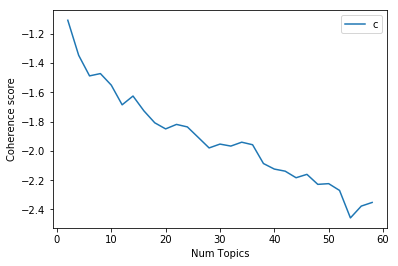

0. u_mass: <<2>> topics have a score of <<-1.1078>>.
1. u_mass: <<4>> topics have a score of <<-1.3471>>.
2. u_mass: <<6>> topics have a score of <<-1.4879>>.
3. u_mass: <<8>> topics have a score of <<-1.472>>.
4. u_mass: <<10>> topics have a score of <<-1.551>>.
5. u_mass: <<12>> topics have a score of <<-1.6854>>.
6. u_mass: <<14>> topics have a score of <<-1.6255>>.
7. u_mass: <<16>> topics have a score of <<-1.7265>>.
8. u_mass: <<18>> topics have a score of <<-1.8082>>.
9. u_mass: <<20>> topics have a score of <<-1.8499>>.
10. u_mass: <<22>> topics have a score of <<-1.8193>>.
11. u_mass: <<24>> topics have a score of <<-1.8364>>.
12. u_mass: <<26>> topics have a score of <<-1.9079>>.
13. u_mass: <<28>> topics have a score of <<-1.9799>>.
14. u_mass: <<30>> topics have a score of <<-1.9537>>.
15. u_mass: <<32>> topics have a score of <<-1.9673>>.
16. u_mass: <<34>> topics have a score of <<-1.9407>>.
17. u_mass: <<36>> topics have a score of <<-1.9581>>.
18. u_mass: <<38>> topics 

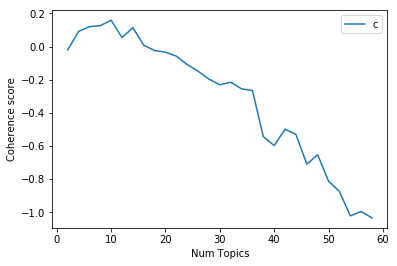

0. c_uci: <<2>> topics have a score of <<-0.0206>>.
1. c_uci: <<4>> topics have a score of <<0.0915>>.
2. c_uci: <<6>> topics have a score of <<0.1198>>.
3. c_uci: <<8>> topics have a score of <<0.1263>>.
4. c_uci: <<10>> topics have a score of <<0.1589>>.
5. c_uci: <<12>> topics have a score of <<0.0539>>.
6. c_uci: <<14>> topics have a score of <<0.1141>>.
7. c_uci: <<16>> topics have a score of <<0.008>>.
8. c_uci: <<18>> topics have a score of <<-0.0239>>.
9. c_uci: <<20>> topics have a score of <<-0.0338>>.
10. c_uci: <<22>> topics have a score of <<-0.0578>>.
11. c_uci: <<24>> topics have a score of <<-0.1086>>.
12. c_uci: <<26>> topics have a score of <<-0.1486>>.
13. c_uci: <<28>> topics have a score of <<-0.1968>>.
14. c_uci: <<30>> topics have a score of <<-0.2302>>.
15. c_uci: <<32>> topics have a score of <<-0.2153>>.
16. c_uci: <<34>> topics have a score of <<-0.2549>>.
17. c_uci: <<36>> topics have a score of <<-0.2655>>.
18. c_uci: <<38>> topics have a score of <<-0.5436

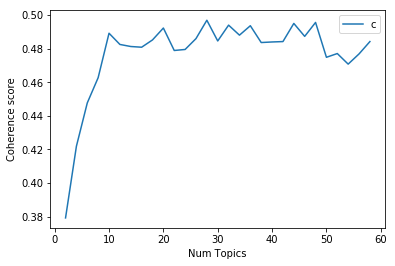

0. c_v: <<2>> topics have a score of <<0.3793>>.
1. c_v: <<4>> topics have a score of <<0.4219>>.
2. c_v: <<6>> topics have a score of <<0.4477>>.
3. c_v: <<8>> topics have a score of <<0.4627>>.
4. c_v: <<10>> topics have a score of <<0.4891>>.
5. c_v: <<12>> topics have a score of <<0.4824>>.
6. c_v: <<14>> topics have a score of <<0.4812>>.
7. c_v: <<16>> topics have a score of <<0.4808>>.
8. c_v: <<18>> topics have a score of <<0.4851>>.
9. c_v: <<20>> topics have a score of <<0.4922>>.
10. c_v: <<22>> topics have a score of <<0.4788>>.
11. c_v: <<24>> topics have a score of <<0.4794>>.
12. c_v: <<26>> topics have a score of <<0.4859>>.
13. c_v: <<28>> topics have a score of <<0.4968>>.
14. c_v: <<30>> topics have a score of <<0.4845>>.
15. c_v: <<32>> topics have a score of <<0.4939>>.
16. c_v: <<34>> topics have a score of <<0.488>>.
17. c_v: <<36>> topics have a score of <<0.4936>>.
18. c_v: <<38>> topics have a score of <<0.4836>>.
19. c_v: <<40>> topics have a score of <<0.483

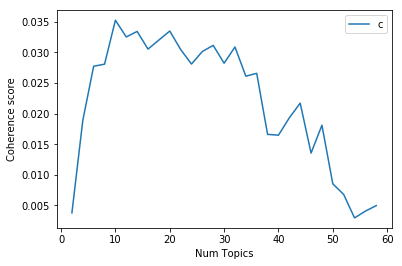

0. c_npmi: <<2>> topics have a score of <<0.0038>>.
1. c_npmi: <<4>> topics have a score of <<0.0189>>.
2. c_npmi: <<6>> topics have a score of <<0.0277>>.
3. c_npmi: <<8>> topics have a score of <<0.0281>>.
4. c_npmi: <<10>> topics have a score of <<0.0352>>.
5. c_npmi: <<12>> topics have a score of <<0.0325>>.
6. c_npmi: <<14>> topics have a score of <<0.0334>>.
7. c_npmi: <<16>> topics have a score of <<0.0305>>.
8. c_npmi: <<18>> topics have a score of <<0.032>>.
9. c_npmi: <<20>> topics have a score of <<0.0335>>.
10. c_npmi: <<22>> topics have a score of <<0.0305>>.
11. c_npmi: <<24>> topics have a score of <<0.0281>>.
12. c_npmi: <<26>> topics have a score of <<0.0301>>.
13. c_npmi: <<28>> topics have a score of <<0.0311>>.
14. c_npmi: <<30>> topics have a score of <<0.0282>>.
15. c_npmi: <<32>> topics have a score of <<0.0309>>.
16. c_npmi: <<34>> topics have a score of <<0.0261>>.
17. c_npmi: <<36>> topics have a score of <<0.0266>>.
18. c_npmi: <<38>> topics have a score of <

In [21]:
for key in v_coherence_values.keys():
    print(f'Coherence score using topic coherence <<{key}>>.')
    v_bins = range(g_start, g_limit, g_step)
    plt.plot(v_bins, v_coherence_values[key])
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc = 'best')
    plt.show()

    # Print the coherence scores
    v_idx = 0
    for num_topics, cv in zip(v_bins, v_coherence_values[key]):
        print(f'{v_idx}. {key}: <<{num_topics}>> topics have a score of <<{round(cv, 4)}>>.')
        v_idx += 1

In [30]:
# Select the model and print the topics
v_optimal_model = v_model_list[4]
pprint(v_optimal_model.show_topics(num_topics = 12, num_words = 24, formatted = True))

[(0,
  '0.039*"hiv" + 0.029*"data" + 0.027*"country" + 0.020*"kenya" + '
  '0.020*"model" + 0.019*"estimate" + 0.015*"population" + 0.013*"prevalence" '
  '+ 0.010*"number" + 0.010*"analysis" + 0.010*"cost" + 0.009*"find" + '
  '0.009*"result" + 0.008*"sub-saharan_africa" + 0.007*"survey" + '
  '0.007*"epidemic" + 0.007*"method" + 0.007*"impact" + 0.007*"change" + '
  '0.007*"increase" + 0.007*"uganda" + 0.007*"site" + 0.006*"coverage" + '
  '0.006*"urban"'),
 (1,
  '0.095*"hiv" + 0.052*"test" + 0.036*"care" + 0.031*"service" + '
  '0.019*"health" + 0.018*"facility" + 0.013*"clinic" + 0.011*"counsel" + '
  '0.010*"provider" + 0.009*"conduct" + 0.009*"study" + 0.008*"client" + '
  '0.008*"kenya" + 0.008*"uptake" + 0.007*"stigma" + 0.007*"barrier" + '
  '0.007*"individual" + 0.007*"offer" + 0.007*"delivery" + '
  '0.007*"hiv-positive" + 0.007*"integrate" + 0.007*"disclosure" + '
  '0.006*"access" + 0.006*"report"'),
 (2,
  '0.051*"child" + 0.026*"age" + 0.024*"mortality" + 0.021*"year" +

In [31]:
v_LDAmodel = gensim.models.ldamodel.LdaModel( id2word             = v_optimal_model.id2word, 
                                              num_topics          = v_optimal_model.num_topics,
                                              alpha               = v_optimal_model.alpha, 
                                              eta                 = v_optimal_model.word_topics,
                                              iterations          = g_iterations,
                                              gamma_threshold     = g_gamma_threshold,
                                              random_state        = g_random_state,
                                              minimum_phi_value   = g_minimum_phi_value,
                                              minimum_probability = g_minimum_probability,
                                              passes              = g_passes,
                                              update_every        = g_update_every,
                                              eval_every          = g_eval_every,
                                              decay               = g_decay,
                                              # param dtype is used in order not to loose precision when converting from MALLET
                                              dtype               = np.float64,
                                              per_word_topics     = True )
v_LDAmodel.expElogbeta[:] = v_optimal_model.wordtopics

# Compute Coherence Score
v_coherenceScore = CoherenceModel( model      = v_LDAmodel, 
                                   texts      = v_documentsWords, 
                                   dictionary = v_id2word, 
                                   coherence  = 'c_v' ).get_coherence()
print('\nCoherence Score: ', v_coherenceScore)

pprint(v_LDAmodel.print_topics(num_topics = 12, num_words = 24))


Coherence Score:  0.4891096203157613
[(0,
  '0.022*"hiv" + 0.016*"data" + 0.015*"country" + 0.011*"kenya" + '
  '0.011*"model" + 0.011*"estimate" + 0.009*"population" + 0.007*"prevalence" '
  '+ 0.006*"number" + 0.006*"analysis" + 0.005*"cost" + 0.005*"find" + '
  '0.005*"result" + 0.005*"sub-saharan_africa" + 0.004*"survey" + '
  '0.004*"epidemic" + 0.004*"method" + 0.004*"change" + 0.004*"impact" + '
  '0.004*"increase" + 0.004*"uganda" + 0.004*"site" + 0.003*"coverage" + '
  '0.003*"urban"'),
 (1,
  '0.054*"hiv" + 0.030*"test" + 0.020*"care" + 0.018*"service" + '
  '0.011*"health" + 0.010*"facility" + 0.008*"clinic" + 0.007*"counsel" + '
  '0.006*"provider" + 0.005*"conduct" + 0.005*"study" + 0.005*"client" + '
  '0.005*"kenya" + 0.005*"uptake" + 0.004*"stigma" + 0.004*"barrier" + '
  '0.004*"individual" + 0.004*"offer" + 0.004*"delivery" + '
  '0.004*"hiv-positive" + 0.004*"integrate" + 0.004*"disclosure" + '
  '0.004*"access" + 0.004*"report"'),
 (2,
  '0.027*"child" + 0.014*"age

In [32]:
pyLDAvis.enable_notebook()
v_data = pyLDAvis.gensim.prepare(v_LDAmodel, v_corpus, v_id2word, mds = 'pcoa')
pyLDAvis.display(v_data)

In [38]:
v_session = createSession()   
createTableNLPTopic(g_engine)    
for topic in v_LDAmodel.show_topics(num_topics = len(v_LDAmodel.get_topics()), num_words = g_num_words):
    v_keywords = topic[1]
    v_NLPTopic = NLPTopic( p_tabPK          = int(topic[0]),
                           p_topicName      = f'Topic {topic[0]}', 
                           p_topicKeywords  = v_keywords )
    v_NLPTopic = v_NLPTopic.recordIU(v_session, p_update = True)
    v_NLPTopic.printShort('Create ')
v_session.close()

Create  {'topicName': 'Topic 0', 'tabPK': 0, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 1', 'tabPK': 1, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 2', 'tabPK': 2, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 3', 'tabPK': 3, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 4', 'tabPK': 4, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 5', 'tabPK': 5, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 6', 'tabPK': 6, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 7', 'tabPK': 7, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 8', 'tabPK': 8, 'topicKeywordsSize': 60}
Create  {'topicName': 'Topic 9', 'tabPK': 9, 'topicKeywordsSize': 60}


### Finding the dominant topic in each document

We want to determine what topic a given document is about. In order to achieve this  we find the topic number that has the highest percentage contribution in a particular document.

In [34]:
pd.set_option('max_colwidth', 180)
v_docTopics = utl_documentTopics( p_model      = v_optimal_model, 
                                  p_corpus     = v_corpus, 
                                  p_documents  = v_documents,
                                  p_num_words  = g_num_words )
display( v_docTopics[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', '10_Content']]
                .sort_values('Perc_Contribution', ascending = False)
                .head(20) )

,Dominant_Topic,Perc_Contribution,Topic_Keywords,10_Content
1493,9.0,0.6795,"hiv-1, infection, response, cell, infect, plasma, level, hiv, vaccine, sequence, study, individual, suggest, subtype, associate, virus, population, antibody, sample, viral, dis...",examine effect hla class haplotype hiv-1 seroconversion disease progression pumwani sex worker cohort study include 595 hiv-1 positive patient 176 hiv negative individual hla-a...
764,8.0,0.6658,"health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, soc...",fogarty international center fic support research capacity development twenty year mission fic support facilitate global health research conduct u.s. international investigator...
1031,8.0,0.6632,"health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, soc...",whether research train program contribute research network development underexplored fogarty international center fic support overseas research train program two decade fic pro...
270,8.0,0.6434,"health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, soc...",strategy transfer international health research train program sub-saharan african institution focus develop cadre local investigator lead program use critical leadership theory...
530,8.0,0.6227,"health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, soc...",address inequity key role international non-governmental organization ingos work health development yet put equity principle practice prove challenge in-depth empirical researc...
1645,8.0,0.6196,"health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, soc...",industry partnership help leverage resource advance hiv/aids vaccine research service delivery policy advocacy goal often involve capacity build international local non-governm...
1749,2.0,0.6138,"child, age, mortality, year, death, adult, rate, disease, incidence, infection, malaria, kenya, factor, status, risk, hiv-infected, hospital, common, identify, case, burden, st...",ethiopia make remarkable progress reduce child mortality last two decade however under-5 mortality rate ethiopia still higher under-5 mortality rate several low- middle-income ...
390,9.0,0.6117,"hiv-1, infection, response, cell, infect, plasma, level, hiv, vaccine, sequence, study, individual, suggest, subtype, associate, virus, population, antibody, sample, viral, dis...",subset woman pumwani sex worker cohort establish 1985 nairobi kenya remain uninfected despite repeat high-risk exposure hiv-exposed seronegative hesn active sex work hesn pheno...
1443,8.0,0.6103,"health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, soc...",kenyan government work international partner local organization develop ehealth strategy specify standard guideline electronic health record adoption public hospital implement ...
1281,9.0,0.6035,"hiv-1, infection, response, cell, infect, plasma, level, hiv, vaccine, sequence, study, individual, suggest, subtype, associate, virus, population, antibody, sample, viral, dis...",mark difference spread prevalence hiv-1 subtypes worldwide difference clinical progression report however biological reason underlie difference unknown gag-protease essential h...


In [39]:
v_session = createSession()   
createTableNLPArticle(g_engine)
for idx in v_docTopics.index.tolist():
    v_PubDocument = PubDocument(v_docTopics.loc[idx, '01_Paper']).loadFromDB(v_session)
    v_values = v_PubDocument.getValues()    
    v_NLPArticle = NLPArticle( p_tabPK           = idx,
                               p_lang            = v_values['__lang__'], 
                               p_title           = v_values['__title__'],
                               p_topic_keywords  = v_docTopics.loc[idx, 'Topic_Keywords'],
                               p_authors         = v_values['__authors__'], 
                               p_authorsDet      = v_values['__authorsDet__'], 
                               p_article_date    = v_values['__paper_Date__'], 
                               p_content         = v_values['__content__'], 
                               p_tokens          = v_values['__tokens__'] )
    v_NLPArticle = v_NLPArticle.recordIU(v_session, p_update = True)
v_session.close()

----------------
### Find the most representative document for each topic

In [36]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = v_docTopics[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', '10_Content']].groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([ sent_topics_sorteddf_mallet, 
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis = 0 )

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
display(sent_topics_sorteddf_mallet)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,10_Content
0,0.0,0.5758,"hiv, data, country, kenya, model, estimate, population, prevalence, number, analysis, cost, find, result, sub-saharan_africa, survey, method, epidemic, change, impact, increase...",variation proportion individual live stable hiv sero-discordant partnership sdp potential driver variability across sub saharan africa ssa still well-understood study aim exami...
1,1.0,0.5727,"hiv, test, care, service, health, facility, clinic, counsel, provider, conduct, study, client, kenya, uptake, stigma, barrier, individual, offer, delivery, hiv-positive, integr...",examine uptake hiv test counsel htc linkage care one year provide htc community health facility test modality among people live kibera informal urban settlement nairobi kenya m...
2,2.0,0.6138,"child, age, mortality, year, death, adult, rate, disease, incidence, infection, malaria, kenya, factor, status, risk, hiv-infected, hospital, common, identify, case, burden, st...",ethiopia make remarkable progress reduce child mortality last two decade however under-5 mortality rate ethiopia still higher under-5 mortality rate several low- middle-income ...
3,3.0,0.5407,"study, group, participant, trial, adherence, intervention, prep, control, method, effect, analysis, drug, day, difference, outcome, score, randomize, measure, compare, report, ...",importance antiretroviral preexposure prophylaxis prep use tenofovir disoproxil fumarate tdf combination emtricitabine/tenofovir disoproxil fumarate ftc+tdf efficacious prevent...
4,4.0,0.5560,"art, patient, treatment, year, initiation, antiretroviral_therapy, month, time, cd4, median, adult, clinical, cd4_count, early, initiate, care, viral_load, receive, outcome, en...",hiv-1 viral load test recommend monitor antiretroviral therapy art universally available aim study ass monitor first-line art switch second-line art sub-saharan africa method c...
5,5.0,0.6022,"hiv, risk, men, partner, sexual, report, sex, prevention, male, female, condom, year, adolescent, factor, age, infection, associate, kenya, woman, behavior, reduce, prevalence,...",child sexual abuse csa intervention draw better understand context csa survey violence age conduct among respondent age 13-17 18-24 year among female 13-17 key perpetrator unwa...
6,6.0,0.5624,"test, sample, result, screen, positive, case, study, clinical, method, prevalence, detection, diagnosis, perform, assay, compare, high, collect, conclusion, kenya, symptom, sen...",tuberculosis control program rwanda currently phase light emit diode-fluorescent microscopy led-fm alternative ziehl-neelsen smear microscopy alongside newly introduce xpert ce...
7,7.0,0.5571,"woman, infant, increase, associate, month, compare, level, maternal, hiv-infected, pregnancy, higher, pmtct, significantly, result, pregnant, conclusion, mother, confidence_int...",prevention mother-to-child hiv-1 transmission pmtct program decrease number hiv-1-infected infant remain important improve growth hiv-1-exposed uninfected infant determine grow...
8,8.0,0.6658,"health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, soc...",fogarty international center fic support research capacity development twenty year mission fic support facilitate global health research conduct u.s. international investigator...
9,9.0,0.6795,"hiv-1, infection, response, cell, infect, plasma, level, hiv, vaccine, sequence, study, individual, suggest, subtype, associate, virus, population, antibody, sample, viral, dis...",examine effect hla class haplotype hiv-1 seroconversion disease progression pumwani sex worker cohort study include 595 hiv-1 positive patient 176 hiv negative individual hla-a...


### Topic distribution across documents

In [37]:
pd.set_option('max_colwidth', 350)

# Number of Documents for Each Topic
v_topicCounts = v_docTopics['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
v_topicContribution = round(v_topicCounts / v_topicCounts.sum(), 4)

# Topic Number and Keywords
v_topicNumKeywords = v_docTopics[['Dominant_Topic', 'Topic_Keywords', 'Perc_Contribution']]

# Merge data
v_topicCounts = pd.DataFrame(v_topicCounts).reset_index()
v_topicCounts.columns = ['Dominant_Topic', 'Number of Documents']

v_topicContribution = pd.DataFrame(v_topicContribution).reset_index()
v_topicContribution.columns = ['Dominant_Topic', 'Percent of Documents']

v_dominantTopics = ( v_topicNumKeywords.merge(v_topicCounts, how = 'left', on = 'Dominant_Topic')
                                       .merge(v_topicContribution, how = 'left', on = 'Dominant_Topic') )

display( v_dominantTopics.groupby(v_dominantTopics.drop('Perc_Contribution', axis = 1).columns.tolist()).agg({'Perc_Contribution': ['min', 'max']})
                         .reset_index()
                         .sort_values('Percent of Documents', ascending = False)
                         .reset_index(drop = True) )

Dominant_Topic  \
                   
0            5.0   
1            8.0   
2            9.0   
3            1.0   
4            4.0   
5            6.0   
6            2.0   
7            7.0   
8            3.0   
9            0.0   

                                                                                                                                                                                                                                                                                                                                                  Topic_Keywords  \
                                                                                                                                                                                                                                                                                                                                                                   
0  hiv, risk, men, partner, sexual, report, sex, prevention, male, female, condom, year, adolescent, factor, age, infection, associate, kenya, woman, behavior, reduce, prevalence, hsv-2, relationship, transmission, circumcision, high, aor, method, association, youth, increase, education, incidence, past, result, male_circumcision, alcohol, include...   
1  health, research, intervention, program, support, community, include, improve, system, kenya, train, provide, focus, study, challenge, implementation, set, policy, address, social, practice, conduct, programme, design, implement, impact, worker, understand, work, influence, qualitative, strategy, identify, district, hiv/aids, develop, future, e...   
2  hiv-1, infection, response, cell, infect, plasma, level, hiv, vaccine, sequence, study, individual, suggest, subtype, associate, virus, population, antibody, sample, viral, disease_progression, association, identify, show, gene, exposure, cohort, isolate, multiple, subtypes, genotype, observe, control, immune, viral_load, analysis, higher, muta...   
3  hiv, test, care, service, health, facility, clinic, counsel, provider, conduct, study, client, kenya, uptake, stigma, barrier, individual, offer, delivery, hiv-positive, integrate, disclosure, access, report, seek, data, method, community, attend, provide, result, status, anc, include, couple, identify, increase, approach, knowledge, integratio...   
4  art, patient, treatment, year, initiation, antiretroviral_therapy, month, time, cd4, median, adult, clinical, cd4_count, early, initiate, care, viral_load, receive, outcome, enrol, rate, age, monitor, clinic, failure, baseline, conclusion, compare, enrollment, stage, ltfu, retention, follow, associate, antiretroviral, program, regimen, kenya, s...   
5  test, sample, result, screen, positive, case, study, clinical, method, prevalence, detection, diagnosis, perform, assay, compare, high, collect, conclusion, kenya, symptom, sensitivity, hiv-positive, laboratory, low, detect, hpv, specimen, blood, evaluate, performance, cervical, infection, find, determine, confirm, diagnostic, diagnose, hiv-neg...   
6  child, age, mortality, year, death, adult, rate, disease, incidence, infection, malaria, kenya, factor, status, risk, hiv-infected, hospital, common, identify, case, burden, study, result, conclusion, associate, data, household, person, rural, individual, method, high, severe, nairobi, present, occur, ratio, tuberculosis, area, include, western...   
7  woman, infant, increase, associate, month, compare, level, maternal, hiv-infected, pregnancy, higher, pmtct, significantly, result, pregnant, conclusion, mother, confidence_interval, transmission, 0.001, method, risk, vs., adjust, visit, cohort, determine, hiv-1_rna, lower, decrease, hiv-1-infected, postpartum, haart, follow, week, association,...   
8  study, group, participant, trial, adherence, intervention, prep, control, method, effect, analysis, drug, day, difference, outcome, score, randomize, measure, compare, report, arm, clinical, reduce,